In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [29]:
G = nx.read_graphml('london.graph')
print(nx.info(G))

Graph with 401 nodes and 467 edges


/tmp/ipykernel_8610/2455874615.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [3]:
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [30]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Uxbridge', {'coords': '(505605.79164161877, 184156.71191985375)'})

## part1 1.1 Centrality measures

In [32]:
def cal_centrality(graph,mode):
    '''
    calculate the betweenness centrality of a graph
    mode = degree, betweenness, or closeness
    '''
    if mode == 'degree':
        cen = nx.degree_centrality(graph)
    elif mode == 'betweenness':
        cen = nx.betweenness_centrality(graph, normalized=False)
    elif mode == 'closeness':
        cen = nx.closeness_centrality(graph)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(graph,cen,mode)

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=graph.nodes())
    df[mode] = pd.Series(nx.get_node_attributes(graph, mode))
    df_sorted = df.sort_values([mode], ascending=False)
    return df_sorted

In [33]:
pos = nx.get_node_attributes(G, 'coords')

In [34]:
list(G.nodes(data = True))[:5]

[('Uxbridge', {'coords': '(505605.79164161877, 184156.71191985375)'}),
 ('Hillingdon', {'coords': '(507544.8588852762, 185008.64550515497)'}),
 ('Ickenham', {'coords': '(508089.8084796285, 185937.75443791348)'}),
 ('Ruislip', {'coords': '(509483.21437480004, 187013.5122156188)'}),
 ('Ruislip Manor', {'coords': '(510118.8736871729, 187242.51348855108)'})]

In [35]:
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

### degree centrality

In [36]:
deg_df = cal_centrality(G,'degree')
deg_df.iloc[:10,:]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Green Park,0.0150
Canning Town,0.0150
Earl's Court,0.0150
West Ham,0.0150
Waterloo,0.0150
Oxford Circus,0.0150


In [37]:
G_top = G.subgraph(deg_df.index[:10])

## betweenness centrality

In [38]:
bet_df_sorted = cal_centrality(G,'betweenness')
bet_df_sorted[0:10]

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


## closeness centrality

In [39]:
clos_df_sorted = cal_centrality(G,'closeness')
clos_df_sorted[0:10]

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


## part1 1.2 impact measures  

## part1 1.3 Node removal

In [40]:
def cal_LCC_eff(graph):
    '''
    calculate LCC and average global efficiency
    '''
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    Gsub = graph.subgraph(Gcc[0])
    
    # calculate the percentage of nodes present in the largest connected components
    percent_lcc = (len(Gsub.nodes)/len(graph.nodes)) * 100
    avg_global_eff = nx.global_efficiency(graph)
    return percent_lcc,avg_global_eff

In [41]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(G.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{node[0]}: {node[1]}' for node in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:100.00%
Graph with 401 nodes and 467 edges
Number of connected components:1
Highest degree nodes: 
 	Stratford: 9
 	Bank and Monument: 8
 	Baker Street: 7
 	King's Cross St. Pancras: 7
 	Liverpool Street: 6


/tmp/ipykernel_8610/1181390539.py:11: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Gsub))


### degree centrality  

#### non-sequential according to degree centrality  

In [42]:
G_rmv_deg = nx.read_graphml('london.graph')
resilience_degree_list = []
for i in range(11):    
    percent_lcc, avg_global_eff = cal_LCC_eff(G_rmv_deg)
    resilience_degree_list.append([percent_lcc, avg_global_eff])
    if i < 10:
        print('moving point:', deg_df.index[i])
        G_rmv_deg.remove_node(deg_df.index[i])

resilience_degree_df = pd.DataFrame(resilience_degree_list, columns=['LCC', 'avg eff'])

moving point: Stratford
moving point: Bank and Monument
moving point: Baker Street
moving point: King's Cross St. Pancras
moving point: Green Park
moving point: Canning Town
moving point: Earl's Court
moving point: West Ham
moving point: Waterloo
moving point: Oxford Circus


In [43]:
resilience_degree_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.085862
3,94.723618,0.082033
4,94.206549,0.075700
5,94.191919,0.074669
6,90.886076,0.069402
7,90.862944,0.067772
8,90.076336,0.066316
9,90.051020,0.064562


#### sequential according to degree centrality  

In [44]:
# remove the points form G according to degree centrality
G_rmv_deg = nx.read_graphml('london.graph')
resilience_deg_list_seq = []
deg_seq_idx = []
for i in range(11):
    deg_cen_df = cal_centrality(G_rmv_deg, 'degree')

    percent_lcc, avg_global_eff = cal_LCC_eff(G_rmv_deg)
    resilience_deg_list_seq.append([percent_lcc, avg_global_eff])

    if i < 10:
        print('moving point:', deg_cen_df.index[i])
        deg_seq_idx.append(deg_cen_df.index[i])
        G_rmv_deg.remove_node(deg_cen_df.index[i])

resilience_deg_seq_df = pd.DataFrame(resilience_deg_list_seq, columns=['LCC', 'avg_eff'])


moving point: Stratford
moving point: Baker Street
moving point: Waterloo
moving point: Green Park
moving point: Euston
moving point: West Ham
moving point: Willesden Junction
moving point: Canning Town
moving point: Hammersmith
moving point: Canary Wharf


In [45]:
resilience_deg_seq_df

,LCC,avg_eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.085012
3,94.723618,0.083238
4,94.710327,0.082180
5,89.141414,0.073257
6,88.607595,0.071012
7,85.279188,0.065481
8,81.679389,0.061550
9,81.632653,0.059832


In [46]:
deg_seq_idx

['Stratford',
 'Baker Street',
 'Waterloo',
 'Green Park',
 'Euston',
 'West Ham',
 'Willesden Junction',
 'Canning Town',
 'Hammersmith',
 'Canary Wharf']

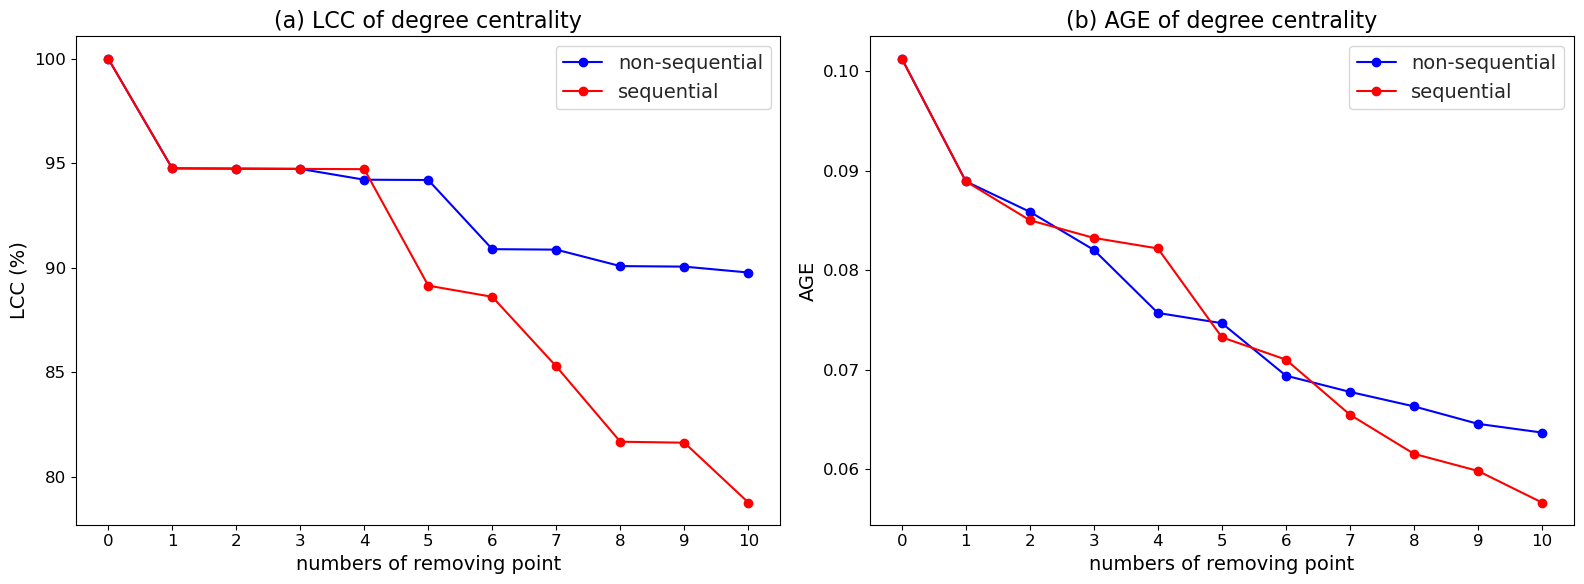

In [47]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)
sns.set(style="whitegrid")

ax[0].set_title('(a) LCC of degree centrality',fontsize=16)
ax[0].plot(resilience_degree_df.iloc[:,0], marker='o',color='blue',label='non-sequential')
ax[0].plot(resilience_deg_seq_df.iloc[:,0], marker='o',color='red',label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
# ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of degree centrality',fontsize=16)
ax[1].plot(resilience_degree_df.iloc[:,1], marker='o',color='blue',label='non-sequential')
ax[1].plot(resilience_deg_seq_df.iloc[:,1], marker='o',color='red',label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)


plt.tight_layout()
plt.savefig('degree centrality.png', dpi=300)
plt.show()

In [48]:
G_top_seq = G.subgraph(deg_seq_idx)

<Figure size 600x400 with 0 Axes>

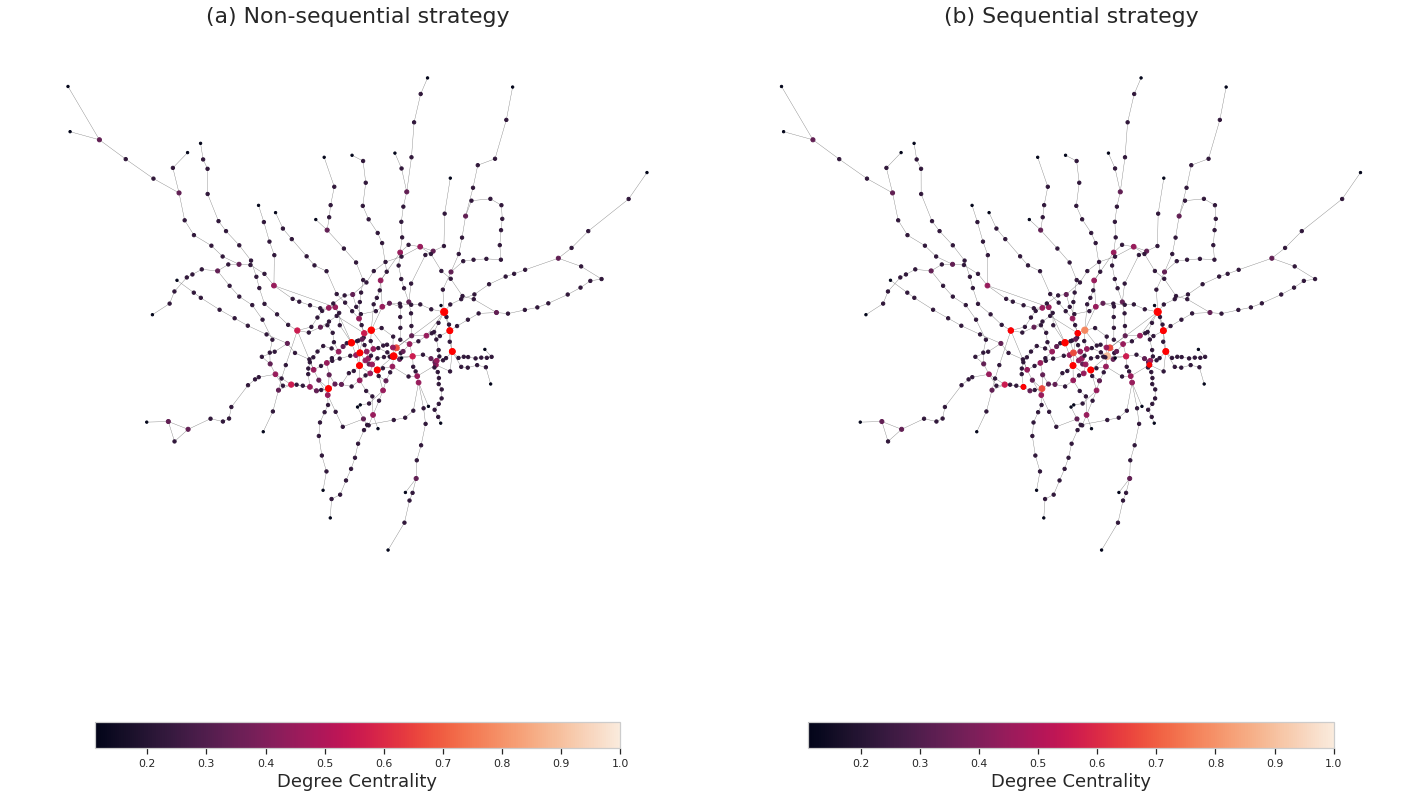

In [125]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['degree']/(max(degree_values)))*50 for i in G_top.nodes(data=True)]
deg_size_seq=[(i[1]['degree']/(max(degree_values)))*50 for i in G_top_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Degree Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Degree Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.savefig('degree centrality1.png', dpi=300)
plt.show()

### betweeness centrality  

#### non-sequential according to betweeness centrality  

In [50]:
G_rmv_bet = nx.read_graphml('london.graph')
resilience_bet_list = []
for i in range(11):    
    percent_lcc, avg_global_eff = cal_LCC_eff(G_rmv_bet)
    resilience_bet_list.append([percent_lcc, avg_global_eff])
    if i < 10:
        print('moving point:', bet_df_sorted.index[i])
        G_rmv_bet.remove_node(bet_df_sorted.index[i])

resilience_bet_df = pd.DataFrame(resilience_bet_list, columns=['LCC', 'avg_eff'])

moving point: Stratford
moving point: Bank and Monument
moving point: Liverpool Street
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Green Park
moving point: Euston
moving point: Westminster
moving point: Baker Street
moving point: Finchley Road


In [51]:
resilience_bet_df

,LCC,avg_eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.085862
3,94.723618,0.084963
4,93.450882,0.078498
5,93.434343,0.075942
6,93.417722,0.074152
7,87.817259,0.068206
8,87.786260,0.067660
9,87.244898,0.064700


#### sequential according to betweeness centrality  

In [52]:
G_rmv_bet = nx.read_graphml('london.graph')
bet_seq_idx = []
bet_list_seq = []
for i in range(11):
    bet_df_sorted = cal_centrality(G_rmv_bet,'betweenness')

    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_bet)
    bet_list_seq.append([percent_lcc,avg_global_eff])
    
    if i < 10:
        print('moving point:',bet_df_sorted.index[0])
        bet_seq_idx.append(bet_df_sorted.index[0])
        G_rmv_bet.remove_node(bet_df_sorted.index[0])
bet_seq_df = pd.DataFrame(bet_list_seq,columns = ['LCC','avg eff'])

moving point: Stratford
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Bank and Monument
moving point: Canada Water
moving point: West Hampstead
moving point: Earl's Court
moving point: Shepherd's Bush
moving point: Euston
moving point: Baker Street


In [53]:
bet_seq_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.084603
3,94.723618,0.081829
4,94.710327,0.077678
5,94.696970,0.072832
6,57.468354,0.053210
7,57.360406,0.051656
8,49.872774,0.045844
9,44.132653,0.041631


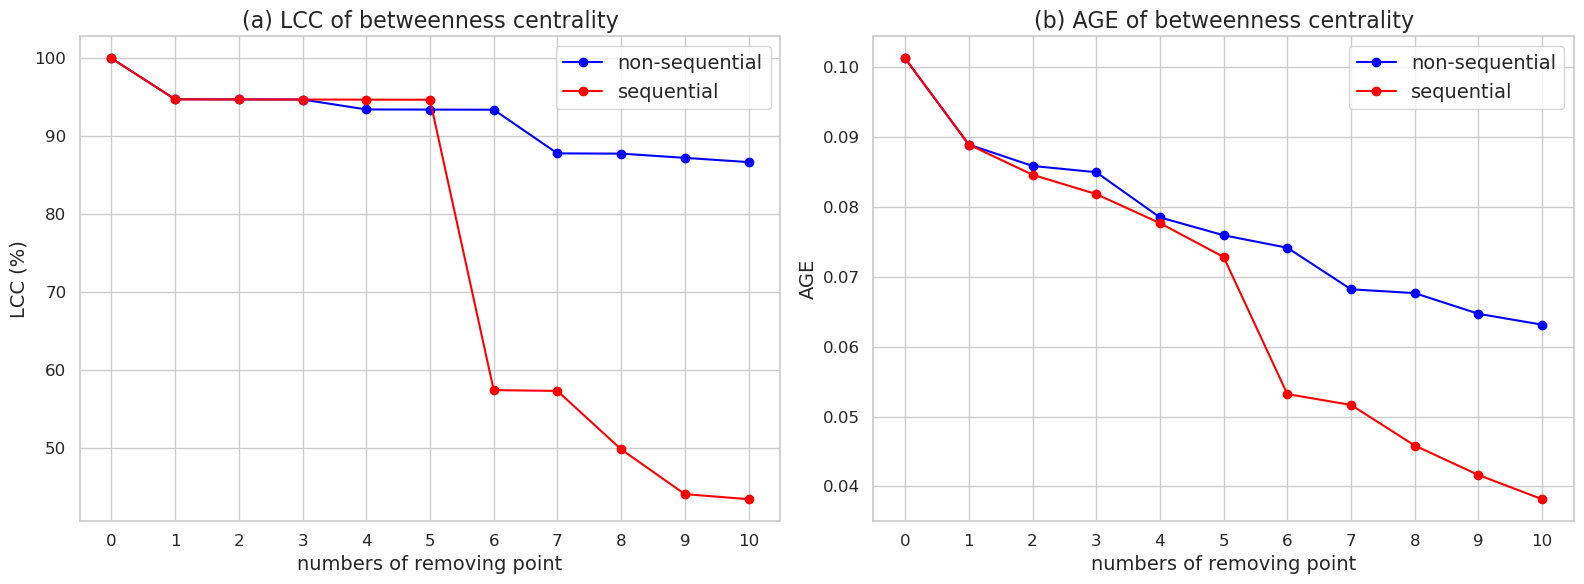

In [54]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)
sns.set(style="whitegrid")

ax[0].set_title('(a) LCC of betweenness centrality',fontsize=16)
ax[0].plot(resilience_bet_df.iloc[:,0], marker='o', color='blue', label='non-sequential')
ax[0].plot(bet_seq_df.iloc[:,0], marker='o', color='red', label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of betweenness centrality',fontsize=16)
ax[1].plot(resilience_bet_df.iloc[:,1], marker='o', color='blue', label='non-sequential')
ax[1].plot(bet_seq_df.iloc[:,1], marker='o', color='red', label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)

plt.tight_layout()
plt.savefig('betweenness centrality.png', dpi=300)
plt.show()


In [55]:
bet_seq_idx

['Stratford',
 "King's Cross St. Pancras",
 'Waterloo',
 'Bank and Monument',
 'Canada Water',
 'West Hampstead',
 "Earl's Court",
 "Shepherd's Bush",
 'Euston',
 'Baker Street']

In [56]:
G_top_bet = G.subgraph(bet_df_sorted.index[:10])
G_top_bet_seq = G.subgraph(bet_seq_idx)

<Figure size 600x400 with 0 Axes>

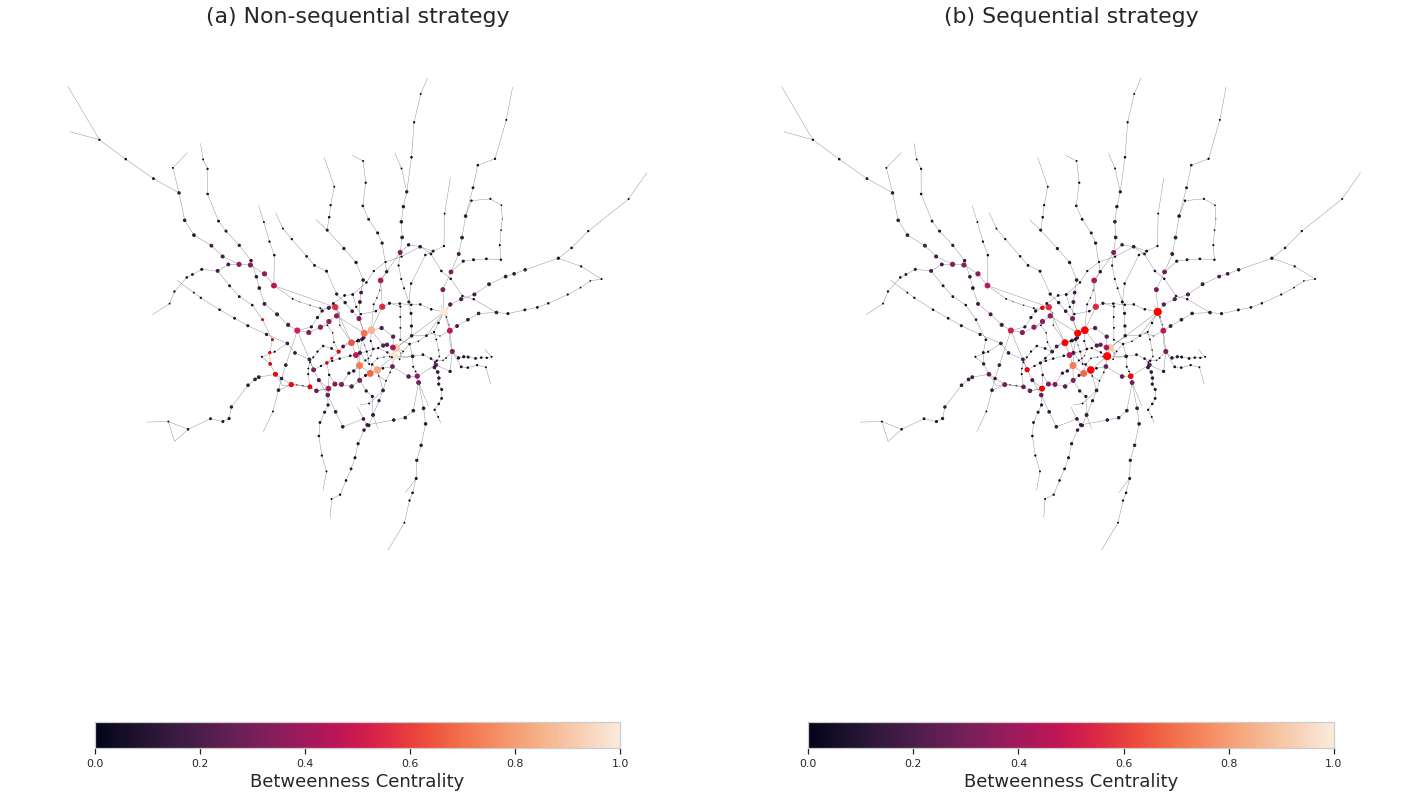

In [124]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]
deg_color=[(i[1]['betweenness']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G_top_bet.nodes(data=True)]
deg_size_seq=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G_top_bet_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top_bet,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_bet_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Betweenness Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Betweenness Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.savefig('Betweenness Centrality1.png', dpi=300)
plt.show()

### closeness centrality  

#### non-sequential according to closeness centrality  

In [58]:
G_rmv_clos = nx.read_graphml('london.graph')
resilience_clos_list = []
for i in range(11):
    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_clos)
    resilience_clos_list.append([percent_lcc,avg_global_eff])
    if i < 10:
        print('moving point:',clos_df_sorted.index[i])
        G_rmv_clos.remove_node(clos_df_sorted.index[i])
resilience_clos_df = pd.DataFrame(resilience_clos_list,columns = ['LCC','avg eff'])

moving point: Green Park
moving point: Bank and Monument
moving point: King's Cross St. Pancras
moving point: Westminster
moving point: Waterloo
moving point: Oxford Circus
moving point: Bond Street
moving point: Farringdon
moving point: Angel
moving point: Moorgate


In [59]:
resilience_clos_df

,LCC,avg eff
0,100.000000,0.101256
1,100.000000,0.099190
2,100.000000,0.094872
3,100.000000,0.087934
4,100.000000,0.087372
5,100.000000,0.084859
6,100.000000,0.082781
7,100.000000,0.082581
8,100.000000,0.082600
9,100.000000,0.082622


In [60]:
G_rmv_clos = nx.read_graphml('london.graph')
resilience_clos_list_seq = []
clos_seq_idx = []
for i in range(11):
    clos_df_sorted = cal_centrality(G_rmv_clos,'closeness')

    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_clos)
    resilience_clos_list_seq.append([percent_lcc,avg_global_eff])
    
    if i < 10:
        print('moving point:',clos_df_sorted.index[0])
        clos_seq_idx.append(clos_df_sorted.index[0])
        G_rmv_clos.remove_node(clos_df_sorted.index[0])
clos_seq_df = pd.DataFrame(resilience_clos_list_seq,columns = ['LCC','avg eff'])

moving point: Green Park
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Bank and Monument
moving point: West Hampstead
moving point: Canada Water
moving point: Stratford
moving point: Earl's Court
moving point: Shepherd's Bush
moving point: Oxford Circus


In [61]:
clos_seq_df

,LCC,avg eff
0,100.000000,0.101256
1,100.000000,0.099190
2,100.000000,0.094435
3,100.000000,0.091816
4,100.000000,0.085426
5,100.000000,0.080544
6,57.215190,0.058101
7,57.360406,0.051884
8,57.251908,0.050350
9,49.744898,0.044395


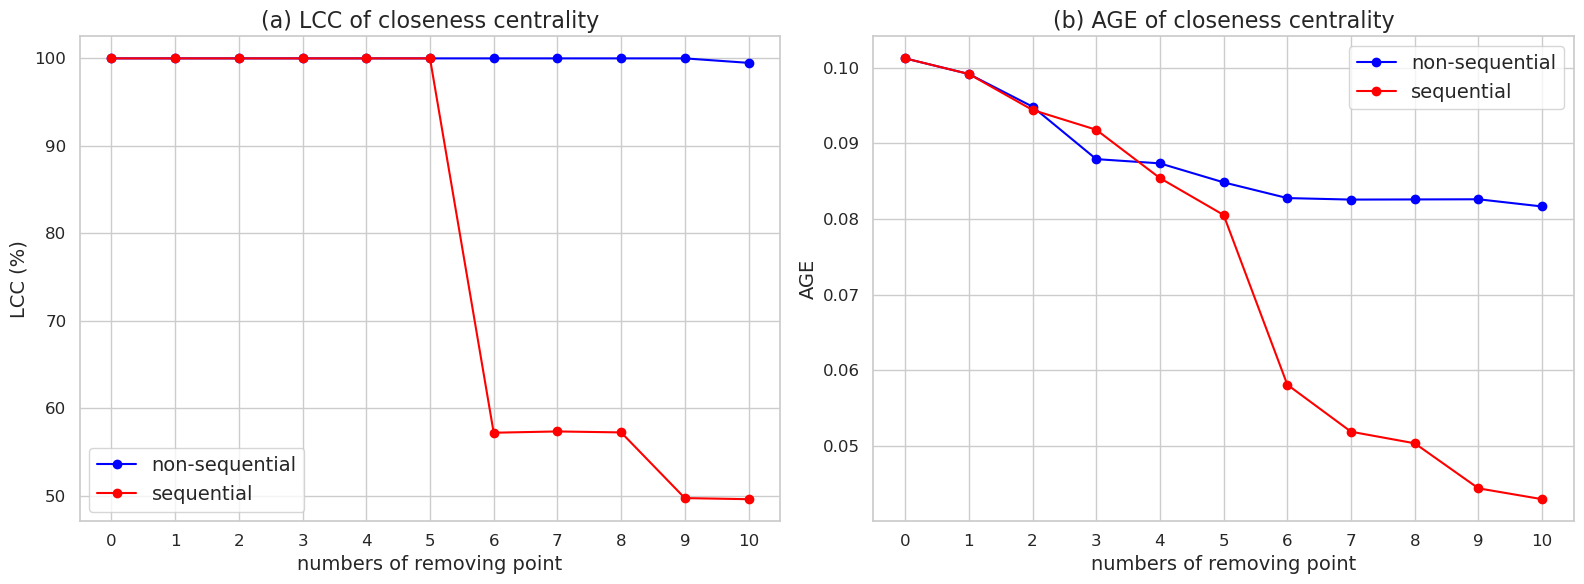

In [62]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)


ax[0].set_title('(a) LCC of closeness centrality',fontsize=16)
ax[0].plot(resilience_clos_df.iloc[:,0],marker='o', color='blue',label='non-sequential')
ax[0].plot(clos_seq_df.iloc[:,0],marker='o', color='red',label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
# ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of closeness centrality',fontsize=16)
ax[1].plot(resilience_clos_df.iloc[:,1],marker='o', color='blue',label='non-sequential')
ax[1].plot(clos_seq_df.iloc[:,1],marker='o', color='red',label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)


plt.tight_layout()
plt.savefig('closeness centrality.png', dpi=300)
plt.show()

<Figure size 600x400 with 0 Axes>

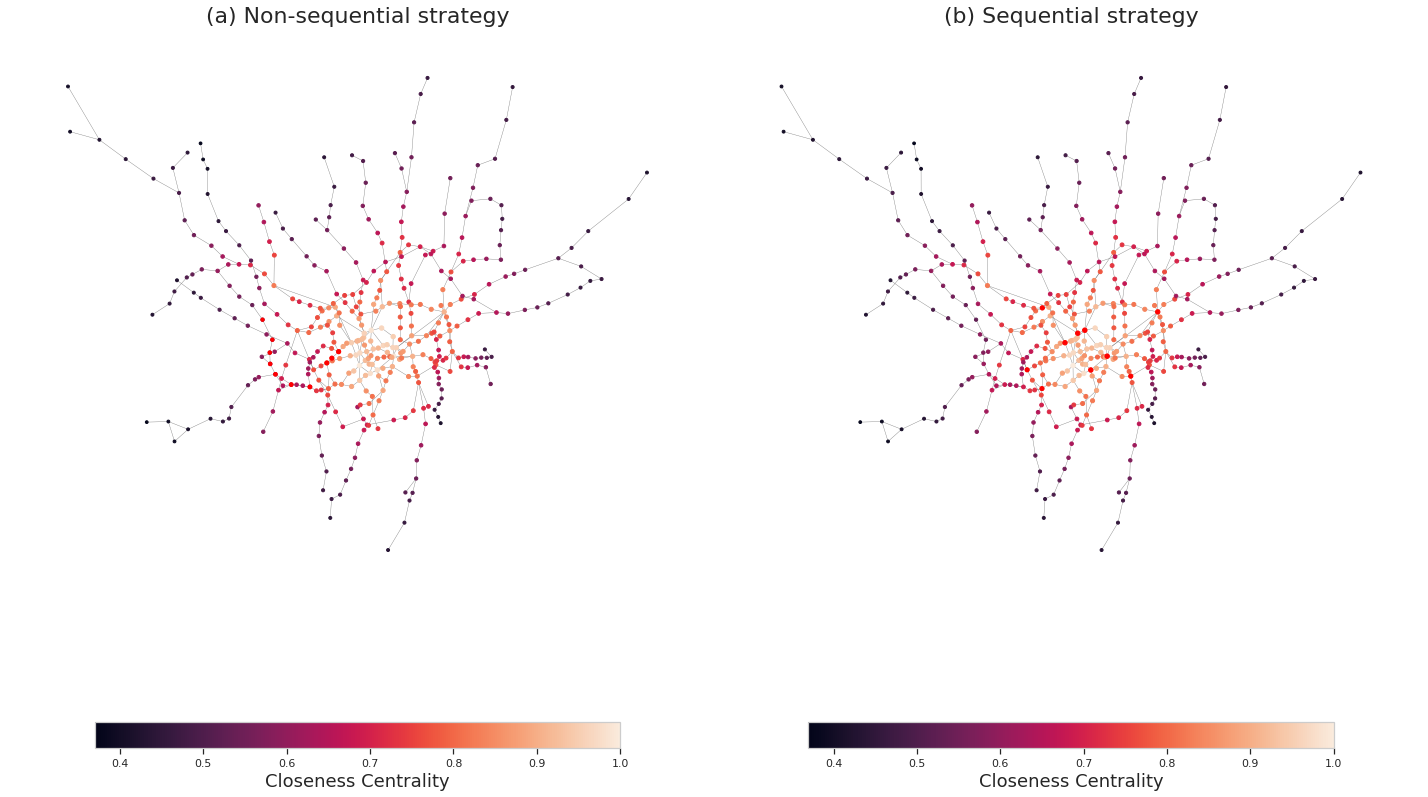

In [123]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['closeness']) for i in G.nodes(data=True)]
deg_color=[(i[1]['closeness']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['closeness']/(max(degree_values)))*20 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['closeness']/(max(degree_values)))*20 for i in G_top_bet.nodes(data=True)]
deg_size_seq=[(i[1]['closeness']/(max(degree_values)))*20 for i in G_top_bet_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top_bet,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_bet_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Closeness Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Closeness Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.savefig('Closeness Centrality1.png', dpi=300)
plt.show()

##  Flows: weighted network

In [63]:
london_flow = pd.read_csv('london_flows.csv')
london_flow.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [64]:
# 读取图
G2 = nx.read_graphml("london.graph")

# 使用以下代码将 flows 添加到图 G2 的边缘权重中
for index, row in london_flow.iterrows():
    origin = row['station_origin']
    destination = row['station_destination']
    flow = row['flows']
    
    if G2.has_edge(origin, destination):
        G2[origin][destination]['inv_flows'] = 1 / (flow + 0.0001)  # 计算流量倒数并存储

# 计算带权介数中心性
cen = nx.betweenness_centrality(G2, normalized=False, weight='inv_flows')

# 将这些值添加到节点属性中：
nx.set_node_attributes(G2, cen, 'betweenness_inv_flows')

# 使用节点作为索引转换为 DataFrame
bet_w = pd.DataFrame(index=G2.nodes())
bet_w['betweenness_inv_flows'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_inv_flows'))
bet_w = bet_w.sort_values(['betweenness_inv_flows'], ascending=False)


In [65]:
# 选择排名前十的站点
top10_unweighted = bet_df_sorted[0:10]
top10_weighted = bet_w.head(10)

# 重置索引，以便将排名添加为新列
top10_unweighted = top10_unweighted.reset_index().rename(columns={'index': 'station_unweighted'})
top10_weighted = top10_weighted.reset_index().rename(columns={'index': 'station_weighted'})

# 使用 concat 函数将两个 DataFrame 拼接在一起
result = pd.concat([top10_unweighted, top10_weighted], axis=1)

result

,station_unweighted,betweenness,station_weighted,betweenness_inv_flows
0,Acton Town,7354.0,Bank and Monument,41881.0
1,Turnham Green,7120.5,Stratford,35791.0
2,Paddington,6753.0,Liverpool Street,31766.0
3,Ealing Common,6640.0,West Ham,28069.0
4,Notting Hill Gate,6397.0,King's Cross St. Pancras,27598.0
5,Bayswater,6384.0,Green Park,24650.0
6,Hammersmith,5253.0,Waterloo,23743.0
7,North Ealing,5160.0,Canning Town,22126.0
8,Park Royal,5070.0,Westminster,21799.0
9,Alperton,4978.0,Moorgate,21695.0


### 2.2 加权平均聚类系数和加权全局效率 理论解释

### 2.3 nodes removal

In [66]:
bet_w[0:3]

,betweenness_inv_flows
Bank and Monument,41881.0
Stratford,35791.0
Liverpool Street,31766.0


In [67]:
Gc = G2.copy()

global_efficiency_values = []
ave_path = []

# Function to calculate weighted global efficiency
def custom_global_efficiency(graph, weight):
    eff_sum = 0
    total_edges = 0

    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2:
                total_edges += 1
                try:
                    eff_sum += 1 / nx.shortest_path_length(graph, node1, node2, weight=weight)
                except nx.NetworkXNoPath:
                    pass

    return eff_sum / total_edges

In [68]:
# Create a copy of the original graph
Gc = G.copy()

# Calculate weighted betweenness centrality
bet_w = nx.betweenness_centrality(Gc, weight='inv_flows', normalized=False)

# Sort nodes by betweenness centrality and get top 3 nodes
sorted_bet_w = dict(sorted(bet_w.items(), key=lambda item: item[1], reverse=True))
top3_nodes = list(sorted_bet_w.keys())[:3]

global_efficiency_values = []
ave_path = []

# Remove top 3 nodes with the highest betweenness centrality and calculate global efficiency and average shortest path
for node in top3_nodes:
    Gc.remove_node(node)
    print("Removed node:", node)
    
    # Calculate weighted global efficiency
    global_efficiency = custom_global_efficiency(Gc, weight='inv_flows')
    global_efficiency_values.append(global_efficiency)
    
    # Find the largest connected component
    Gcc = sorted(nx.connected_components(Gc), key=len, reverse=True)
    G_largest_cc = Gc.subgraph(Gcc[0])
    
    ave_shortest_path = round(nx.average_shortest_path_length(G_largest_cc, weight='inv_flows'), 6)
    ave_path.append(ave_shortest_path)


Removed node: Stratford
Removed node: Bank and Monument
Removed node: Liverpool Street


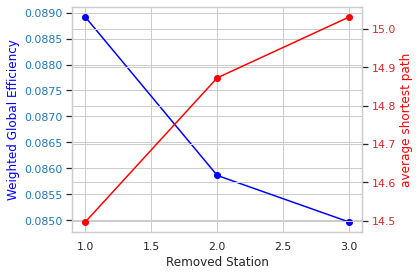

In [69]:
# Plot the results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Removed Station')
ax1.set_ylabel('Weighted Global Efficiency', color='blue')
ax1.plot(range(1, 4), global_efficiency_values, color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('average shortest path', color='red')
ax2.plot(range(1, 4),  ave_path, color='red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.savefig('part2_3.png', dpi=300)
plt.show()

Removed node with highest betweenness centrality: Stratford
Removed node with highest betweenness centrality: King's Cross St. Pancras
Removed node with highest betweenness centrality: Waterloo


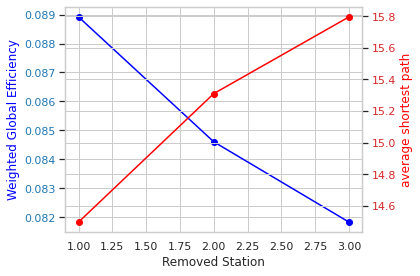

In [43]:
# Create a copy of the original graph
Gcb = G.copy()

# Add station_name attribute to nodes
for n in Gcb.nodes:
    Gcb.nodes[n]['station_name'] = n

global_efficiency_values = []
ave_path = []

# Remove top 3 nodes with the highest betweenness centrality and calculate global efficiency and average shortest path
for i in range(3):
    # Calculate weighted betweenness centrality
    bet_w = nx.betweenness_centrality(Gcb, weight='inv_flows', normalized=False)
    
    # Sort nodes by betweenness centrality and get the node with the highest betweenness centrality
    sorted_bet_w = dict(sorted(bet_w.items(), key=lambda item: item[1], reverse=True))
    node_to_remove = list(sorted_bet_w.keys())[0]
    node_name = Gcb.nodes[node_to_remove]['station_name']
    
    # Remove node with the highest betweenness centrality
    Gcb.remove_node(node_to_remove)
    
    # Calculate weighted global efficiency
    global_efficiency = custom_global_efficiency(Gcb, weight='inv_flows')
    global_efficiency_values.append(global_efficiency)
    
    # Find the largest connected component
    Gcc = sorted(nx.connected_components(Gcb), key=len, reverse=True)
    G_largest_cc = Gcb.subgraph(Gcc[0])
    
    ave_shortest_path = round(nx.average_shortest_path_length(G_largest_cc, weight='inv_flows'), 6)
    ave_path.append(ave_shortest_path)
    
    print("Removed node with highest betweenness centrality:", node_name)

# Plot the results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Removed Station')
ax1.set_ylabel('Weighted Global Efficiency', color='blue')
ax1.plot(range(1, 4), global_efficiency_values, color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('average shortest path', color='red')
ax2.plot(range(1, 4),  ave_path, color='red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.savefig('part2_4.png', dpi=300)
plt.show()

## Part 2: Spatial Interaction models

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import scipy.stats
from math import sqrt

In [46]:
#pre-processing the data 

def data_preprocess(df):
    '''
    data preprocess
    '''
    df = df[df['population'] != 0]
    df = df[df['jobs'] != 0]
    df = df[df['distance'] != 0]
    df = df.reset_index()

    df['log_pop'] = df['population']
    df['log_jobs'] = df['jobs']
    df['log_dis'] = df['distance']

    df['log_pop'] = df['log_pop'].apply(lambda x: math.log(x))
    df['log_jobs'] = df['log_jobs'].apply(lambda x: math.log(x))
    df['log_dis'] = df['log_dis'].apply(lambda x: math.log(x))
    return df

In [48]:
flow = london_flow.copy()
flow = data_preprocess(flow)
flow.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [49]:
# R-Squared & RMSE
import scipy.stats


def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

## Testing Unconstrained Model (Inverse Power & Negative Exponential)

In [52]:
#create the formula
formula_u = 'flows ~ log_pop + log_jobs + log_dis' 
#run the regression
uncosim = smf.glm(formula = formula_u, data=flow, family=sm.families.Poisson()).fit()

In [54]:
#inverse power
predictionsu =uncosim.get_prediction(flow[["log_pop", "log_jobs", "log_dis"]])
predictions_summary_frameu = predictionsu.summary_frame()
flow["uncosimest"] = np.round(uncosim.mu,0)

In [55]:
#Unconstrained Model using Inverse Power
betau = uncosim.params[-1]
R2u = CalcRSqaured(flow["flows"], flow["uncosimest"])
RMSEu = CalcRMSE(flow["flows"], flow["uncosimest"])
print(betau)
print(R2u)
print(RMSEu)

-0.6228020552901641
0.3211903577361867
108.334


In [56]:
#negative exponential
formula_u1 = 'flows ~ log_pop + log_jobs + distance'  #dis
uncosim1 = smf.glm(formula = formula_u1, data=flow, family=sm.families.Poisson()).fit()

In [58]:
predictionsu1 =uncosim1.get_prediction(flow[["log_pop", "log_jobs", "distance"]])
predictions_summary_frameu1 = predictionsu1.summary_frame()
flow["uncosimest1"] = np.round(uncosim1.mu)

In [59]:
#Unconstrained Model using NE
betau1 = uncosim1.params[-1]
R2u1 = CalcRSqaured(flow["flows"], flow["uncosimest1"])
RMSEu1 = CalcRMSE(flow["flows"], flow["uncosimest1"])
print(betau1)
print(R2u1)
print(RMSEu1)

-9.036708790741632e-05
0.3622475513232857
105.723


## Testing Object-Constrained Model (Inverse Power & Negative Exponential)

In [77]:
#Object-Constrained Model using IP

formula_ob = 'flows ~ station_origin + log_jobs + log_dis -1' 
obsim = smf.glm(formula = formula_ob, data=flow, family=sm.families.Poisson()).fit()

predictions =obsim.get_prediction(flow[["station_origin", "log_jobs","log_dis"]])
predictions_summary_frameob = predictions.summary_frame()
flow["obsimest"] = np.round(obsim.mu)

betaob = obsim.params[-1]
R2ob = CalcRSqaured(flow["flows"], flow["obsimest"])
RMSEob = CalcRMSE(flow["flows"], flow["obsimest"])
print(betaob)
print(R2ob)
print(RMSEob)

-0.8781191183724256
0.3882763950178627
102.893


In [78]:
#Object-Constrained Model using NE
formula_ob1 = 'flows ~ station_origin + log_jobs + distance -1' 
obsim1 = smf.glm(formula = formula_ob1, data=flow, family=sm.families.Poisson()).fit()

predictionsob1 =obsim1.get_prediction(flow[["station_origin", "log_jobs","distance"]])
predictions_summary_frameob1 = predictionsob1.summary_frame()
flow["obsimest1"] = np.round(obsim1.mu)

betaob1 = obsim1.params[-1]
R2ob1 = CalcRSqaured(flow["flows"], flow["obsimest1"])
RMSEob1 = CalcRMSE(flow["flows"], flow["obsimest1"])
print(betaob1)
print(R2ob1)
print(RMSEob1)

-0.0001531661934636155
0.4680648443542884
96.263


## Testing Destination Constrained Model (Inverse Power & Negative Exponential)

In [80]:
formula_d = 'flows ~ station_destination + log_pop + log_dis -1' 
dessim = smf.glm(formula = formula_d, data=flow, family=sm.families.Poisson()).fit()
#inverse power
predictionsd =dessim.get_prediction(flow[["station_destination", "log_pop", "log_dis"]])
predictions_summary_framed = predictionsd.summary_frame()
flow["dessimest"] = np.round(dessim.mu)

In [81]:
# Destination Constrained Model using IP
betad = dessim.params[-1]
R2d = CalcRSqaured(flow["flows"], flow["dessimest"])
RMSEd = CalcRMSE(flow["flows"], flow["dessimest"])
print(betad)
print(R2d)
print(RMSEd)

-0.6351480703753105
0.3499323840939915
106.013


In [87]:
formula_d1 = 'flows ~ station_destination + log_pop + distance -1' 
dessim1 = smf.glm(formula = formula_d1, data=flow, family=sm.families.Poisson()).fit()
#negative exponential
predictionsd1 =dessim1.get_prediction(flow[["station_destination", "log_pop", "distance"]])
predictions_summary_framed1 = predictionsd1.summary_frame()
flow["dessimest1"] = np.round(dessim1.mu)

In [89]:
betad1 = dessim1.params[-1]
R2d1 = CalcRSqaured(flow["flows"], flow["dessimest1"])
RMSEd1 = CalcRMSE(flow["flows"], flow["dessimest1"])
print(betad1)
print(R2d1)
print(RMSEd1)

-9.9632857153213e-05
0.39995419556248446
102.168


## Testing Doubly Constrained Model (Inverse Power & Negative Exponential)

In [90]:
formula_do = 'flows ~ station_origin + station_destination + log_dis -1'
doubsim = smf.glm(formula = formula_do, data=flow, family=sm.families.Poisson()).fit()

In [91]:
#Doubly Constrained Model using IP
flow["doubsimest"] = np.round(doubsim.predict()) 
betado = doubsim.params[-1]
R2do = CalcRSqaured(flow["flows"], flow["doubsimest"])
RMSEdo = CalcRMSE(flow["flows"], flow["doubsimest"])
print(betado)
print(R2do)
print(RMSEdo)

-0.9096317604932728
0.40768532292960646
101.335


In [93]:
formula_do1 = 'flows ~ station_origin + station_destination + distance -1'
doubsim1 = smf.glm(formula = formula_do1, data=flow, family=sm.families.Poisson()).fit()

In [94]:
#Doubly Constrained Model using NE
flow["doubsimest1"] = np.round(doubsim1.predict()) 
betado1 = doubsim1.params[-1]
R2do1 = CalcRSqaured(flow["flows"], flow["doubsimest1"])
RMSEdo1 = CalcRMSE(flow["flows"], flow["doubsimest1"])
print(betado1)
print(R2do1)
print(RMSEdo1)

-0.00015436969215469831
0.497842741463233
93.401


In [95]:
## I would use the Doubly Constrained Model using NE model, let's check it
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Sun, 07 May 2023   Deviance:                   1.5299e+06
Time:                        23:21:21   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [98]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flow.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flow = flow.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flow.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flow = flow.merge(D_j, on = "station_destination", how = "left" )

In [125]:
# pulling out the parameter values
coefs = pd.DataFrame(doubsim1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

london_flows_new = flow.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
london_flows_new.drop(columns = ["coef"], inplace = True)

#check this has worked
london_flows_new.head()

/tmp/ipykernel_4535/1581376928.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,...,obsimest,obsimest1,dessimest,dessimest1,doubsimest,doubsimest1,O_i_x,O_i_y,D_j,alpha
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,...,55.0,78.0,53.0,71.0,55.0,77.0,599,599,78549,1.35415
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,...,1.0,1.0,3.0,3.0,2.0,3.0,599,599,442,1.35415
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,...,3.0,4.0,4.0,5.0,3.0,4.0,599,599,665,1.35415
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,...,66.0,99.0,70.0,93.0,77.0,112.0,599,599,58772,1.35415
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,...,49.0,56.0,33.0,36.0,45.0,48.0,599,599,15428,1.35415


In [214]:
alpha = doubsim1.params[0:-2]
gamma = doubsim1.params[-2]
beta = -doubsim1.params[-1]
beta

0.00015436969215469831

##  Scenarios

In [73]:
london_flow_A = pd.read_csv('london_flows.csv')
cw = london_flow_A[london_flow_A['station_destination'] == 'Canary Wharf']
cw['jobs'] = cw['jobs'] / 2
london_flow_A['new_jobs'] = london_flow_A['jobs']
london_flow_A.loc[cw.index,'new_jobs'] = cw['jobs']

london_flow_A = london_flow_A[london_flow_A['jobs'] != 0]
london_flow_A = london_flow_A.reset_index()
london_flow_A['log_jobs'] = london_flow_A['jobs']
london_flow_A['log_jobs'] = london_flow_A['log_jobs'].apply(lambda x: math.log(x))
london_flow_A['log_new_jobs'] = london_flow_A['new_jobs']
london_flow_A['log_new_jobs'] = london_flow_A['log_new_jobs'].apply(lambda x: math.log(x))

london_flow_A.head()

/tmp/ipykernel_8610/423512544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw['jobs'] = cw['jobs'] / 2


,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549,11.271478,11.271478
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442,6.091310,6.091310
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665,6.499787,6.499787
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386,10.981421,10.288274
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428,9.643939,9.643939


In [74]:
cdatasubmat1 = pd.pivot_table(london_flow_A, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

In [75]:
formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
orig_cosim = smf.glm(formula = formula_nega_dis, data=london_flow_A, family=sm.families.Poisson()).fit()

In [76]:
coefs = pd.DataFrame(orig_cosim.params)
coefs = coefs.reset_index()

alpha_i = coefs.iloc[0:399,:]
alpha_i.columns = ['origin','alpha_i']
to_repl = ['(station_origin)','\[','\]']
for x in to_repl:
    alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')

gamma_j = coefs.iloc[399:-1,:]
gamma_j.columns = ['destination','gamma_j']

/tmp/ipykernel_8610/1982675945.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')
/tmp/ipykernel_8610/1982675945.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')


In [78]:
beta = coefs.iloc[-1,:]
beta.columns = ['distance','beta']
minus_beta = beta.iloc[1] # with minus symbol

london_flow_A = london_flow_A.merge(alpha_i,left_on='station_origin',right_on='origin',how='left')
london_flow_A['est'] = np.exp(london_flow_A['alpha_i'] + 
                                    gamma_j.iloc[0,1]*london_flow_A['log_jobs'] + 
                                    minus_beta*london_flow_A['distance'])

london_flow_A["est"] = round(london_flow_A["est"],0)

In [79]:
london_flow_A.head()

,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs,origin,alpha_i,est
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549,11.271478,11.271478,Abbey Road,-2.881019,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442,6.091310,6.091310,Abbey Road,-2.881019,2.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665,6.499787,6.499787,Abbey Road,-2.881019,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386,10.981421,10.288274,Abbey Road,-2.881019,99.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428,9.643939,9.643939,Abbey Road,-2.881019,56.0


In [80]:
london_flow_A['est2'] = np.exp(london_flow_A['alpha_i'] + 
                                    gamma_j.iloc[0,1]*london_flow_A['log_new_jobs'] + 
                                    minus_beta*london_flow_A['distance'])

london_flow_A["est2"] = round(london_flow_A["est2"],0)
london_flow_A.head()

,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs,origin,alpha_i,est,est2
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549,11.271478,11.271478,Abbey Road,-2.881019,78.0,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442,6.091310,6.091310,Abbey Road,-2.881019,2.0,2.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665,6.499787,6.499787,Abbey Road,-2.881019,4.0,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386,10.981421,10.288274,Abbey Road,-2.881019,99.0,59.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428,9.643939,9.643939,Abbey Road,-2.881019,56.0,56.0


In [81]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = london_flow_A["jobs"]**gamma_j.iloc[0,1]
dist_beta = london_flow_A["distance"].apply(lambda x: math.exp(x*minus_beta))
# dist_beta = math.exp(london_flow_A["distance"]*minus_beta)
#calcualte the first stage of the Ai values
london_flow_A["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
london_flow_A = london_flow_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [82]:
O_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flow_A = london_flow_A.merge(O_i, on = "station_origin", how = "left" )
#to check everything works, recreate the original estimates
london_flow_A["est3"] = london_flow_A["A_i"]*london_flow_A["O_i"]*Dj2_gamma*dist_beta
#round
london_flow_A["est3"] = round(london_flow_A["est3"])
#check
london_flow_A[["est", "est3"]].head()

,est,est3
0,78.0,78.0
1,2.0,2.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0


In [83]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = london_flow_A["log_new_jobs"]**gamma_j.iloc[0,1]
#calcualte the first stage of the Ai values
london_flow_A["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
london_flow_A = london_flow_A.merge(A_i, left_on="station_origin", right_index=True, how="left")
#to check everything works, recreate the original estimates
london_flow_A["est4"] = london_flow_A["A_i2"]*london_flow_A["O_i"]*Dj3_gamma*dist_beta
#round
london_flow_A["est4"] = round(london_flow_A["est4"])
cdatasubmat2 = london_flow_A.pivot_table(values ="est4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1227.0
Acton Town,NaN,NaN,NaN,9.0,9.0,NaN,45.0,0.0,NaN,11.0,...,11.0,11.0,3.0,40.0,NaN,1.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,4.0,NaN,43.0,NaN,NaN,0.0,NaN,32.0,...,3.0,NaN,7.0,7.0,NaN,4.0,NaN,3.0,NaN,2886.0
Aldgate East,NaN,NaN,4.0,46.0,NaN,NaN,2.0,0.0,NaN,33.0,...,3.0,3.0,7.0,7.0,NaN,5.0,NaN,3.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,3.0,32.0,39.0,NaN,NaN,NaN,NaN,23.0,...,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4874.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,4.0,17.0,16.0,NaN,2.0,NaN,NaN,27.0,...,3.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [84]:
scena_A_result = london_flow_A[['station_origin','station_destination','est4','flows']]
scena_A_result['diff'] = scena_A_result['est4'] - scena_A_result['flows']

/tmp/ipykernel_8610/2514804242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scena_A_result['diff'] = scena_A_result['est4'] - scena_A_result['flows']


In [ ]:
scena_A_result.sort_values('diff')

,station_origin,station_destination,est4,flows,diff
55930,Waterloo,Bank and Monument,810.0,15946,-15136.0
55955,Waterloo,Canary Wharf,362.0,8085,-7723.0
50080,Stratford,Liverpool Street,438.0,6946,-6508.0
32644,London Bridge,Canary Wharf,247.0,6165,-5918.0
54808,Victoria,Oxford Circus,463.0,5181,-4718.0
...,...,...,...,...,...
27849,Ilford,Manor Park,713.0,19,694.0
19694,Gidea Park,Romford,743.0,42,701.0
56049,Waterloo,Lambeth North,778.0,64,714.0
56126,Waterloo,Southwark,928.0,109,819.0


In [ ]:
scena_A_result['2beta_diff'] = scena_B_result['SIM_est_2beta'] - scena_B_result['flows'] 

,est_sum,flow_sum,change_num
station_destination,,,
Bank and Monument,13066.0,78549,-65483.0
Canary Wharf,10292.0,58772,-48480.0
Liverpool Street,13443.0,61122,-47679.0
Stratford,13919.0,55954,-42035.0
Oxford Circus,11434.0,44368,-32934.0
...,...,...,...
Caledonian Road,6978.0,1803,5175.0
Stepney Green,7172.0,1879,5293.0
Hyde Park Corner,8033.0,2410,5623.0


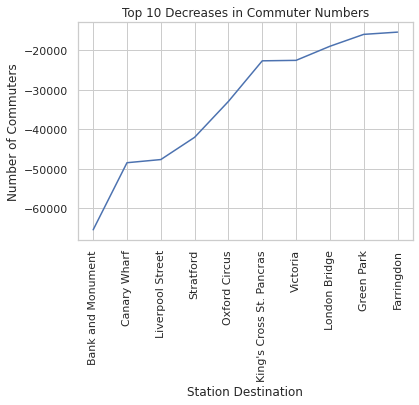

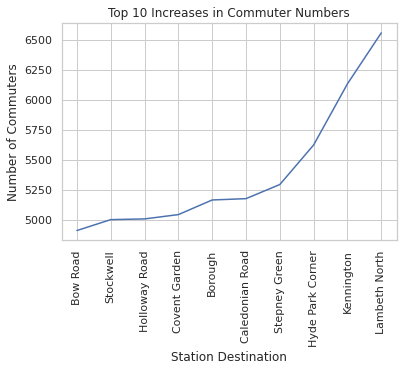

In [87]:
import matplotlib.pyplot as plt

# plot top 10 decreases
top10_decreases = scena_A_diff[scena_A_diff['change_num']<0].head(10)
plt.plot(top10_decreases.index, top10_decreases['change_num'])
plt.title('Top 10 Decreases in Commuter Numbers')
plt.xlabel('Station Destination')
plt.ylabel('Number of Commuters')
plt.xticks(rotation=90)
plt.show()

# plot top 10 increases
top10_increases = scena_A_diff[scena_A_diff['change_num']>0].tail(10)
plt.plot(top10_increases.index, top10_increases['change_num'])
plt.title('Top 10 Increases in Commuter Numbers')
plt.xlabel('Station Destination')
plt.ylabel('Number of Commuters')
plt.xticks(rotation=90)
plt.show()

In [88]:
G_plot = nx.read_graphml('london.graph')
G_plot = G_plot.subgraph(scena_A_diff.index)
for node in G_plot.nodes():
    G_plot.nodes[node]['coords'] = eval(G_plot.nodes[node]['coords'])
nx.set_node_attributes(G_plot, scena_A_diff['change_num'], 'change_num')
nx.set_node_attributes(G_plot, scena_A_diff['est_sum'], 'est_flows')
nx.set_node_attributes(G_plot, scena_A_diff['flow_sum'], 'real_flows')

list(G_plot.nodes(data = True))[0]

('Uxbridge',
 {'coords': (505605.79164161877, 184156.71191985375),
  'change_num': -3260.0,
  'est_flows': 1056.0,
  'real_flows': 4316})

In [89]:
#plot a measure in network graph to visualize

reduce_flow = scena_A_diff[scena_A_diff['change_num'] < 0]
increase_flow = scena_A_diff[scena_A_diff['change_num'] >= 0]
G_reduce = G_plot.subgraph(reduce_flow.index)
G_increase = G_plot.subgraph(increase_flow.index)
list(G_reduce.nodes(data = True))[0]

('South Kensington',
 {'coords': (526934.4279193364, 178814.8327666811),
  'change_num': -6724.0,
  'est_flows': 8601.0,
  'real_flows': 15325})

<Figure size 600x400 with 0 Axes>

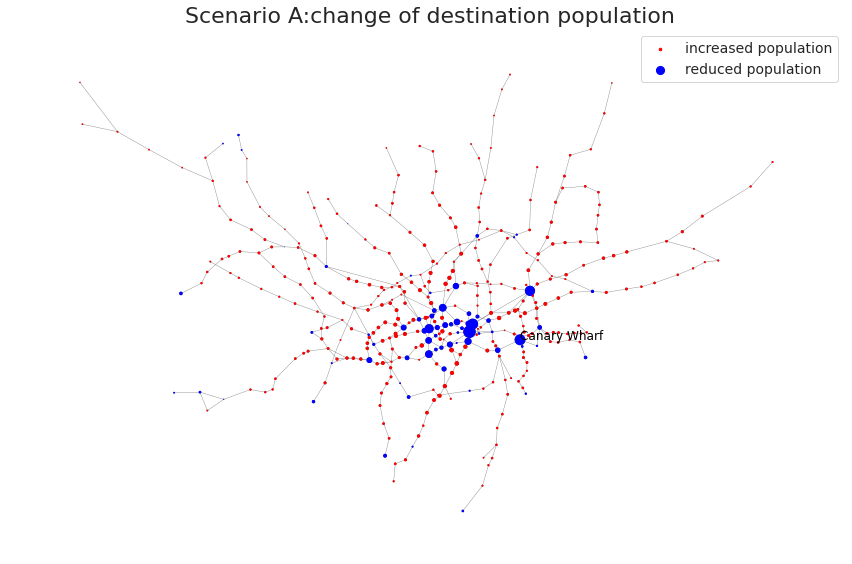

In [94]:
# Lets set colour and size of nodes according to betweenness values

ratio_values=[(abs(i[1]['change_num'])) for i in G_plot.nodes(data=True)]
ratio_size=[(abs(i[1]['change_num']))/500 for i in G_plot.nodes(data=True)]
ratio_size_increase=[(abs(i[1]['change_num']))/500 for i in G_increase.nodes(data=True)]
ratio_size_reduce=[(abs(i[1]['change_num']))/500 for i in G_reduce.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G_plot, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_edges(G_plot, pos,edge_color='gray', 
        width=0.4,ax=ax)

nod=nx.draw_networkx_nodes(G_plot,
        pos = pos,
        node_color= 'grey',
        node_size= ratio_size,
        ax=ax)

nx.draw_networkx_nodes(G_increase,
        pos = pos,
        node_color= 'red',
        label='increased population',
        node_size= ratio_size_increase,
        ax=ax)
nx.draw_networkx_nodes(G_reduce,
        pos = pos,
        node_color= 'blue',
        label='reduced population',
        node_size= ratio_size_reduce,
        ax=ax)

ax.text(x=537586.6947649193,y=180311.85419390627,s='Canary Wharf',color='black',fontsize=12)
ax.axis("off")
ax.set_title(" Scenario A:change of destination population",fontsize=22)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('scenarioA.png', dpi=300)
plt.show()

# B

In [5]:
london_flow_doubly = pd.read_csv('london_flows.csv')
london_flow_doubly = london_flow_doubly[london_flow_doubly['distance'] != 0]
london_flow_doubly.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [9]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_doubly, family=sm.families.Poisson()).fit()
coefs = pd.DataFrame(doubly_cosim_nega_dis.params)
coefs = coefs.reset_index()

In [10]:
alpha_i = coefs.iloc[0:399,:]
alpha_i.columns = ['origin','alpha_i']

to_repl = ['(station_origin)','\[','\]']
for x in to_repl:
    alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')

alpha_i.head()

/tmp/ipykernel_8610/3185225526.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')
/tmp/ipykernel_8610/3185225526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')


,origin,alpha_i
0,Abbey Road,1.354150
1,Acton Central,2.965314
2,Acton Town,2.780711
3,Aldgate,1.537233
4,Aldgate East,1.625544


In [11]:
gamma_j = coefs.iloc[399:-1,:]
gamma_j.columns = ['destination','gamma_j']

to_repl = ['(station_destination)','\[','\]']
for x in to_repl:
    gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')

for i in range(len(gamma_j)):
    gamma_j.iloc[i,0] = gamma_j.iloc[i,0].replace('T.','')

gamma_j.head()

/tmp/ipykernel_8610/3852289031.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')
/tmp/ipykernel_8610/3852289031.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')


,destination,gamma_j
399,Acton Central,1.486103
400,Acton Town,1.440836
401,Aldgate,2.222441
402,Aldgate East,2.153787
403,All Saints,0.163051


In [12]:
beta = coefs.iloc[-1,:]
beta.columns = ['distance','beta']
minus_beta = beta.iloc[1] # with minus symbol

print('beta:',minus_beta)

beta: -0.00015436969215814773


In [13]:
london_flow_doubly = london_flow_doubly.merge(alpha_i,left_on='station_origin',right_on='origin',how='left')
london_flow_doubly = london_flow_doubly.merge(gamma_j,left_on='station_destination',right_on='destination',how='left')
london_flow_doubly['est'] = np.exp(london_flow_doubly['alpha_i'] + 
                                    london_flow_doubly['gamma_j'] + 
                                    minus_beta*london_flow_doubly['distance'])

london_flow_doubly['est'] = round(london_flow_doubly["est"])
london_flow_doubly = london_flow_doubly.drop(columns=['destination','origin'],axis=1)

In [14]:
O_i = pd.DataFrame(london_flow_doubly.groupby(["station_origin"])["flows"].agg(np.sum))
O_i = O_i.reset_index()
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flow_doubly.groupby(["station_destination"])["flows"].agg(np.sum))
D_j = D_j.reset_index()
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(D_j, on = "station_destination", how = "left" )

In [16]:
def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
             # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [17]:
london_flow_doubly.head()

,station_origin,station_destination,flows,population,jobs,distance,alpha_i,gamma_j,est,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,1.35415,4.242924,77.0,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,1.35415,0.944441,3.0,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,1.35415,0.527704,4.0,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.35415,4.148524,112.0,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,1.35415,2.856294,48.0,599,15428


In [18]:
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',minus_beta,'exponential','Ai_new','Bj_new')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_1beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_new'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_new'] * 
                                   np.exp(london_flow_doubly['distance']*minus_beta))
# Check out the matrix
cdatasubmat3 = pd.pivot_table(cdatasub,values='SIM_est_1beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
Iteration: 1

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23


In [106]:
new_minus_beta = minus_beta * 2
new_minus_beta

-0.00030163478067259277

In [107]:
new_minus_beta = minus_beta * 2
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',new_minus_beta,'exponential','Ai_dou_beta','Bj_dou_beta')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_2beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_dou_beta'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_dou_beta'] * 
                                   np.exp(london_flow_doubly['distance']*new_minus_beta))
# Check out the matrix
cdatasubmat_dou_beta = pd.pivot_table(cdatasub,values='SIM_est_2beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46


In [23]:
cdatasubmat_dou_beta

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,602.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1220.0
Acton Town,0,0,0,4,3,0,13,0,0,5,...,28,1,0,32,0,0,0,0,0,3749.0
Aldgate,0,0,0,0,48,0,0,0,0,27,...,1,0,1,1,0,0,0,0,0,2881.0
Aldgate East,0,0,0,60,0,0,0,0,0,28,...,1,0,1,1,0,0,0,0,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,38,52,0,0,0,0,18,...,1,0,2,0,0,0,0,0,0,4861.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,526.0
Woodside Park,0,0,0,10,8,0,0,0,0,25,...,2,0,1,0,0,0,0,0,0,3089.0


In [108]:
triple_minus_beta = minus_beta * 3
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',triple_minus_beta,'exponential','Ai_tri_beta','Bj_tri_beta')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_3beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_tri_beta'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_tri_beta'] * 
                                   np.exp(london_flow_doubly['distance']*triple_minus_beta))
# Check out the matrix
cdatasubmat_tri_beta = pd.pivot_table(cdatasub,values='SIM_est_3beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [ ]:
cdatasubmat_tri_beta

In [109]:
# beta
cdatasub[['SIM_est_1beta','SIM_est_2beta','SIM_est_3beta','flows']]

,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,flows
0,77.0,53.0,41.0,0
1,3.0,2.0,1.0,1
2,4.0,3.0,3.0,3
3,112.0,113.0,109.0,1
4,48.0,62.0,73.0,37
...,...,...,...,...
61451,185.0,123.0,85.0,127
61452,176.0,166.0,125.0,608
61453,27.0,21.0,17.0,6
61454,132.0,190.0,260.0,81


In [110]:
# calculate diff
scena_B_result = cdatasub[['station_origin','station_destination','SIM_est_1beta','SIM_est_2beta','SIM_est_3beta','flows']]
scena_B_result.head()

,station_origin,station_destination,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,flows
0,Abbey Road,Bank and Monument,77.0,53.0,41.0,0
1,Abbey Road,Beckton,3.0,2.0,1.0,1
2,Abbey Road,Blackwall,4.0,3.0,3.0,3
3,Abbey Road,Canary Wharf,112.0,113.0,109.0,1
4,Abbey Road,Canning Town,48.0,62.0,73.0,37


In [114]:
scena_B_result['2beta_diff'] = scena_B_result['SIM_est_2beta'] - scena_B_result['flows'] 
scena_B_result['3beta_diff'] = scena_B_result['SIM_est_3beta'] - scena_B_result['flows'] 
scena_B_result

,station_origin,station_destination,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,flows,2beta_diff,3beta_diff,abs_2beta_diff,abs_3beta_diff
0,Waterloo,Bank and Monument,4557.0,5483.0,5907.0,15946,-10463.0,-10039.0,10463.0,10039.0
1,Waterloo,Canary Wharf,1949.0,1075.0,434.0,8085,-7010.0,-7651.0,7010.0,7651.0
2,London Bridge,Canary Wharf,1286.0,916.0,470.0,6165,-5249.0,-5695.0,5249.0,5695.0
3,London Bridge,Bank and Monument,2962.0,4535.0,6112.0,445,4090.0,5667.0,4090.0,5667.0
4,Liverpool Street,Bank and Monument,2921.0,4602.0,6165.0,812,3790.0,5353.0,3790.0,5353.0
...,...,...,...,...,...,...,...,...,...,...
61451,Gants Hill,Arnos Grove,2.0,0.0,0.0,0,0.0,0.0,0.0,0.0
61452,Ravenscourt Park,Heathrow Terminal 4,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
61453,West Ham,Harrow & Wealdstone,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
61454,Parsons Green,Harrow-on-the-Hill,2.0,0.0,0.0,0,0.0,0.0,0.0,0.0


/tmp/ipykernel_8610/2205424211.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=o_d_2beta,rotation=90)
/tmp/ipykernel_8610/2205424211.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=o_d_3beta,rotation=90)


<Figure size 600x400 with 0 Axes>

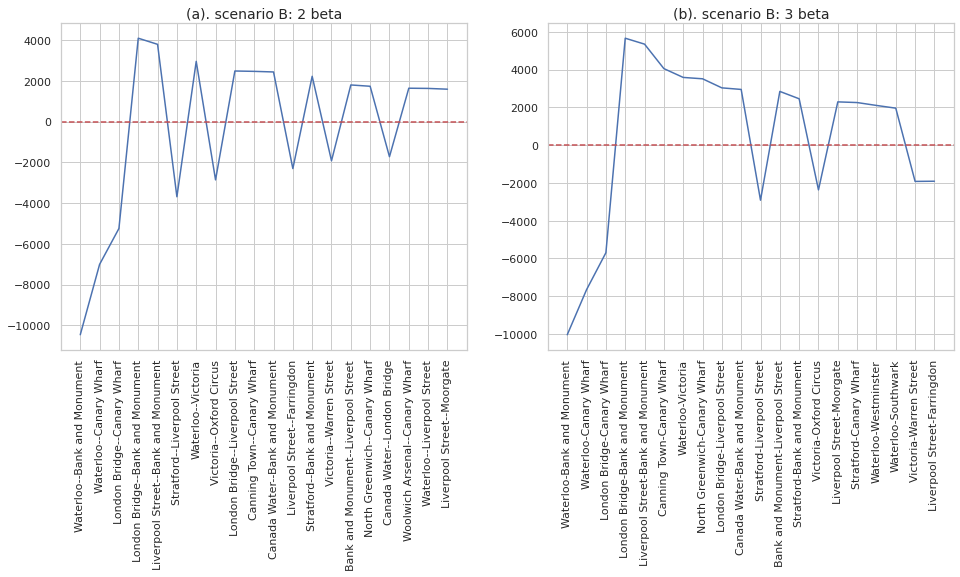

In [113]:
plt.figure(dpi=100)
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,2,figsize=(16,6))
scena_B_result['abs_2beta_diff'] = abs(scena_B_result['2beta_diff'])
scena_B_result['abs_3beta_diff'] = abs(scena_B_result['3beta_diff'])
o_d_2beta = []
o_d_3beta = []

scena_B_result = scena_B_result.sort_values('abs_2beta_diff',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
for i in range(20):
    o_d_2beta.append(scena_B_result.iloc[i,0] + '--' + scena_B_result.iloc[i,1])
ax[0].plot(o_d_2beta,scena_B_result.loc[:19,'2beta_diff'])
ax[0].hlines(0, -1, 30, colors = "r", linestyles = "dashed")
ax[0].set_xlim(-1,20)
ax[0].set_title('(a). scenario B: 2 beta',fontsize=14)
ax[0].set_xticklabels(labels=o_d_2beta,rotation=90)

scena_B_result = scena_B_result.sort_values('abs_3beta_diff',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
for i in range(20):
    o_d_3beta.append(scena_B_result.iloc[i,0] + '-' + scena_B_result.iloc[i,1])
ax[1].plot(o_d_3beta,scena_B_result.loc[:19,'3beta_diff'])
ax[1].hlines(0, -1, 30, colors = "r", linestyles = "dashed")
ax[1].set_xlim(-1,20)
ax[1].set_title('(b). scenario B: 3 beta',fontsize=14)
ax[1].set_xticklabels(labels=o_d_3beta,rotation=90)
plt.show()

<Figure size 600x400 with 0 Axes>

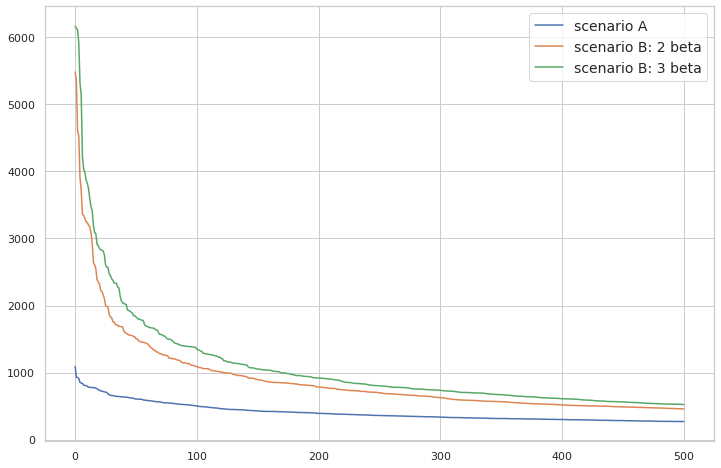

In [118]:
plt.figure(dpi=100)
fig, ax = plt.subplots(figsize=(12,8))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="whitegrid")

# ax[0].hist(scena_A_diff['flow_sum'])
scena_A_result = scena_A_result.sort_values('est4',ascending=False).reset_index()
scena_A_result = scena_A_result.drop(columns='index')
ax.plot(scena_A_result.loc[:500,'est4'],label='scenario A')

scena_B_result = scena_B_result.sort_values('SIM_est_2beta',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
x_pt = np.arange(0,len(scena_B_result))
ax.plot(scena_B_result.loc[:500,'SIM_est_2beta'],label='scenario B: 2 beta')

scena_B_result = scena_B_result.sort_values('SIM_est_3beta',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
ax.plot(scena_B_result.loc[:500,'SIM_est_3beta'],label='scenario B: 3 beta')

plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.legend(fontsize=14)
plt.show()